In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('poster')
import random
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
nlp = spacy.load('en')
import nltk
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import time
import multiprocessing

### Data and Preprocessing 

This data set contains questions asked on quora and can be found on kaggle.
(https://www.kaggle.com/c/quora-insincere-questions-classification/data)

Data fields:

qid - unique question identifier

question_text - Quora question text

target - a question labeled "insincere" has a value of 1, otherwise 0

The data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

In [19]:
df = pd.read_csv('quora.csv')

In [20]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [21]:
df.shape

(1306122, 3)

In [22]:
documents = df.question_text.values

In [23]:
documents[:3]

array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?'],
      dtype=object)

In [24]:
print('Number of documents:  {0}'.format(len(documents)))
instances = [str(i).split() for i in documents]
tokens_quora = []
for i in range(len(instances)):
    for j in range(len(instances[i])):
        tokens_quora.append(instances[i][j])
print('Number of tokens:    {0}'.format(len(tokens_quora)))
print('Number of types:       {0}'.format(len(set(tokens_quora))))

Number of documents:  1306122
Number of tokens:    16723076
Number of types:       508823


#### Lemmatizing (Don't  run) 

In [20]:
stopwords = nltk.corpus.stopwords.words('english')

In [22]:
%%time
instances = [[token.lemma_ for token in nlp(sentence) if token.pos_ in {'NOUN', 'VERB', 'PROPN', 'ADJ', 'ADV'} and not token.lemma_ in stopwords]
          for sentence in documents]

Wall time: 3h 13min 6s


In [23]:
instances[:3]

[['quebec', 'nationalist', 'see', '-PRON-', 'province', 'nation', '1960'],
 ['adopt', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop'],
 ['velocity', 'affect', 'time', 'velocity', 'affect', 'space', 'geometry']]

#### Saving the clean text to save 3 hours every time we run the code 

In [ ]:
X = []
for j in range(len(instances)):
    x = ''
    for i in (instances[j]):
        x += i + ' '
    X.append(x)

In [151]:
X[:3]

['quebec nationalist see -PRON- province nation 1960 ',
 'adopt dog would encourage people adopt shop ',
 'velocity affect time velocity affect space geometry ']

In [154]:
df['clean_text'] = X

In [155]:
df.target.replace(to_replace=[0, 1], value = ['sincere', 'insincere'], inplace=True)

In [156]:
df.head()

,qid,question_text,target,clean_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,sincere,quebec nationalist see -PRON- province nation ...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",sincere,adopt dog would encourage people adopt shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,sincere,velocity affect time velocity affect space geo...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,sincere,otto von guericke use magdeburg hemisphere
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,sincere,convert montra helicon mountain bike change tyre


In [157]:
df.to_csv('clean_text.csv', index = False)

#### Loading data with clean text

In [25]:
df_clean = pd.read_csv('clean_text.csv')

In [26]:
df_clean.head()

,qid,question_text,target,clean_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,sincere,quebec nationalist see -PRON- province nation ...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",sincere,adopt dog would encourage people adopt shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,sincere,velocity affect time velocity affect space geo...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,sincere,otto von guericke use magdeburg hemisphere
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,sincere,convert montra helicon mountain bike change tyre


In [27]:
documents = df_clean['clean_text'].values

In [28]:
instances = [str(i).split() for i in documents]

In [29]:
instances[:3]

[['quebec', 'nationalist', 'see', '-PRON-', 'province', 'nation', '1960'],
 ['adopt', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop'],
 ['velocity', 'affect', 'time', 'velocity', 'affect', 'space', 'geometry']]

In [30]:
print('Number of documents: {0}'.format(len(documents)))
tokens_processed_quora = []
for i in range(len(instances)):
    for j in range(len(instances[i])):
        tokens_processed_quora.append(instances[i][j])
print('Number of tokens:    {0}'.format(len(tokens_processed_quora)))
print('Number of types:      {0}'.format(len(set(tokens_processed_quora))))

Number of documents: 1306122
Number of tokens:    8372844
Number of types:      185018


We can see that after preprocessing the number of tokens and types was reduced to less than a half of the original data

### Analysis 

#### Topic modeling with LDA 

The goal of this analysis is to find out what topics are discussed on quora and whether there is a difference between sincere questions and insincere questions.

In [31]:
# read in instances and create Dictionary object with information about frequencies
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=300, no_above=0.5)
print(dictionary, flush=True)

Dictionary(3559 unique tokens: ['-PRON-', 'nation', 'see', 'adopt', 'dog']...)


In [32]:
%%time
# replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

# start with a small number of topics and increase the size until topics are well separated
num_topics = 10

num_passes = 20
chunk_size = len(model_corpus) * num_passes/500
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(model_corpus,
                     num_topics=num_topics,
                     id2word=dictionary,
                     workers=multiprocessing.cpu_count()-1,
                     passes=num_passes,
                     chunksize=chunk_size
                    )

translating corpus to IDs
tf-idf transformation
52244.88
fitting model
Wall time: 43min 45s


In [37]:
import re

# transform the data into topic distros
topic_corpus = model[model_corpus]

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=7)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:7]))
    descriptors.append(", ".join(m[:5]).replace('"', ''))

1 "good", "get", "college", "engineering", "university", "student", "course"
2 "book", "mean", "trump", "study", "exam", "mark", "class"
3 "know", "people", "would", "think", "world", "thing", "-PRON-"
4 "-PRON-", "girl", "woman", "feel", "love", "man", "make"
5 "country", "people", "india", "english", "-PRON-", "good", "muslims"
6 "-PRON-", "work", "benefit", "job", "get", "pay", "bank"
7 "-PRON-", "water", "cause", "effect", "would", "body", "use"
8 "good", "use", "-PRON-", "buy", "app", "movie", "website"
9 "quora", "question", "answer", "-PRON-", "value", "social", "ask"
10 "difference", "become", "tip", "famous", "useful", "influence", "good"


In [34]:
%%time
# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(topic_corpus))]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
# add the review category of each document (so we can aggregate)
topic_distros['category'] = df_clean.target

Wall time: 5min 7s


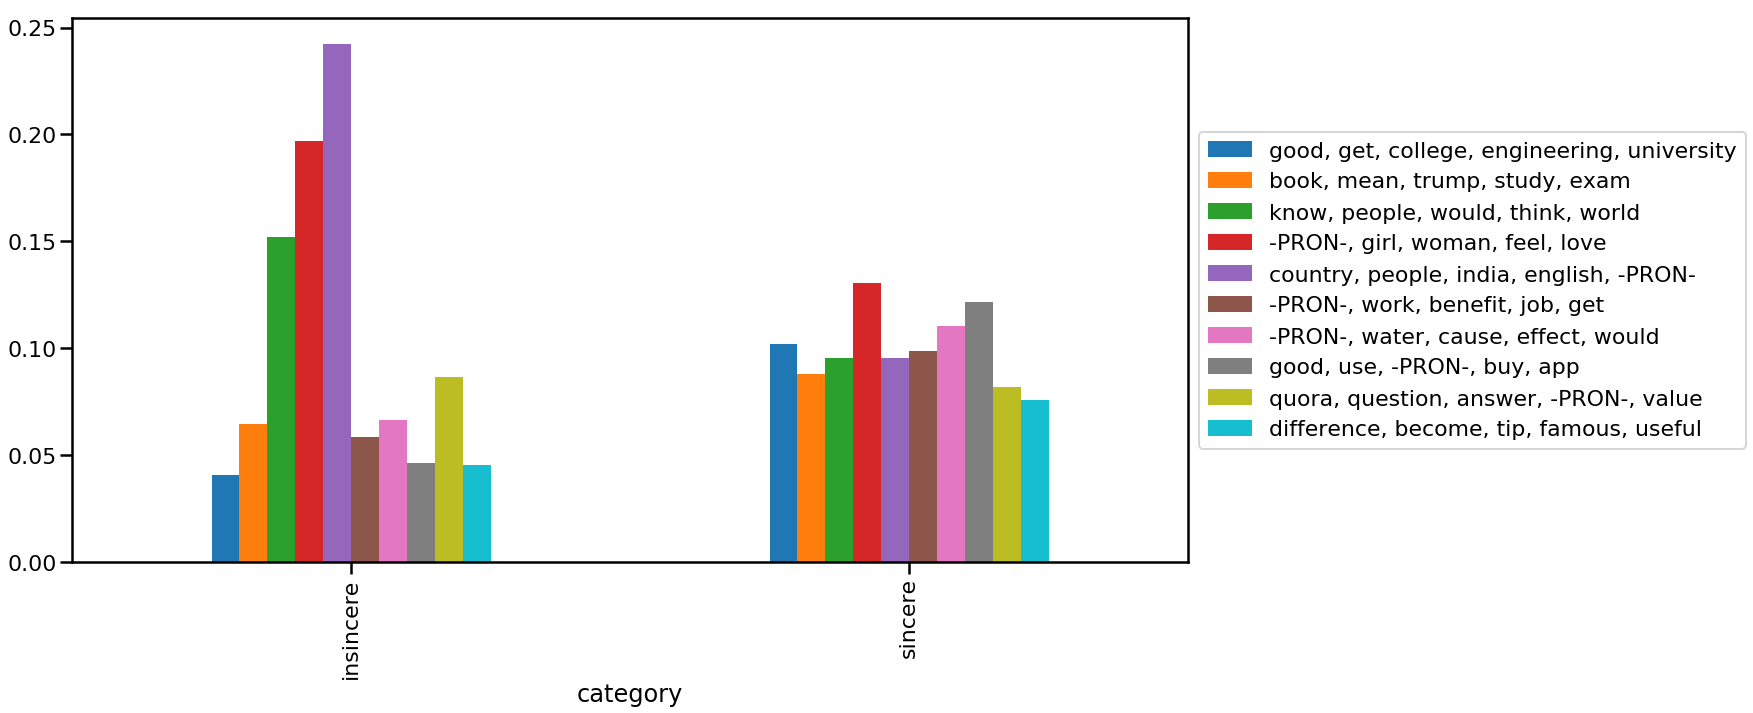

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt # make graphs
import seaborn # make prettier graphs

seaborn.set_context('poster') # use large font

fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by review categories
aggregate_by_category = topic_distros.groupby(topic_distros.category).mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

It seems like the topics discussed among the sincere questions have the same frequency and among the insincere questions people tend to talk more about specific topics.

#### Word embedding 

The goal of this analysis is to find some relationships between words in our corpus.

In [37]:
%%time
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION

corpus = instances

w2v_model = Word2Vec(size=300, 
                     window=15, 
                     hs=0,
                     sample=0.000001,
                     negative=5, 
                     min_count=100,
                     workers=-1, 
                     iter=100
)

w2v_model.build_vocab(corpus)

w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

Wall time: 1min 12s


In [50]:
w2v_model.wv.most_similar(positive=['trump'], negative=['american'], topn=1)

[('fascism', 0.22239002585411072)]

#### Clustering 

The goal of this analysis is to find out whether there are different groups with similar words inside the group in our corpus.

Preparing data

In [8]:
instances[0]

['quebec', 'nationalist', 'see', '-PRON-', 'province', 'nation', '1960']

In [9]:
X = []
for j in range(len(instances)):
    x = ''
    for i in (instances[j]):
        x += i + ' '
    X.append(x)

In [10]:
X[0]

'quebec nationalist see -PRON- province nation 1960 '

Agglomerative Clustering

In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD

k = 2

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english', analyzer='word', min_df=0.001, max_df=0.5, sublinear_tf=True, use_idf=True)

X = tfidf_vectorizer.fit_transform(X)

print(X.shape)
# reduce the dimensionality of the input
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

(1306122, 1069)
Wall time: 3min 10s


In [12]:
agg = AgglomerativeClustering(n_clusters=k)

sample = np.random.choice(len(X2), replace=False, size=50000)
%time agg_sample = agg.fit_predict(X2[sample])

Wall time: 15min 35s


Notes for the big dataset:

Size is limited to 50000 questions for feasable computation time. Besides the nature of agglomerative clustering that takes increasingly more time to compute when the size increases, I also noticed that at a certain point the computer ran out of RAM and started using SSD, which made it at least 10 times slower.

On the other hand, increasing the size of agglomerative clustering made k-means faster, because it was initialized with better centroids.

K-means

In [13]:
# let's get the centroid/average of each cluster
centroids = np.array([X2[sample][agg_sample == c].mean(axis=0) for c in range(k)])
# initialize k-means with the agglomerative clusters
km = KMeans(n_clusters=k, n_jobs=-1, init=centroids)

%time km.fit(X2)

C:\Users\elton\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Wall time: 56.2 s


KMeans(algorithm='auto', copy_x=True,
    init=array([[ 6.87090e-02,  4.20296e-03, ...,  1.51541e-06,  2.59622e-04],
       [ 4.10300e-01,  8.80167e-01, ..., -2.24254e-03,  2.74368e-03]]),
    max_iter=300, n_clusters=2, n_init=10, n_jobs=-1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('poster')


def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. If supplied, color them according to the labels
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('afmhot') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            ax.scatter(df2['x'], df2['y'], df2['z'], c=label_colors[l], cmap=cMap, edgecolor=None, label=label, alpha=0.3, s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            ax.scatter(df2['x'], df2['y'], c=label_colors[l], cmap=cMap, edgecolor=None, label=label, alpha=0.3, s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.show()

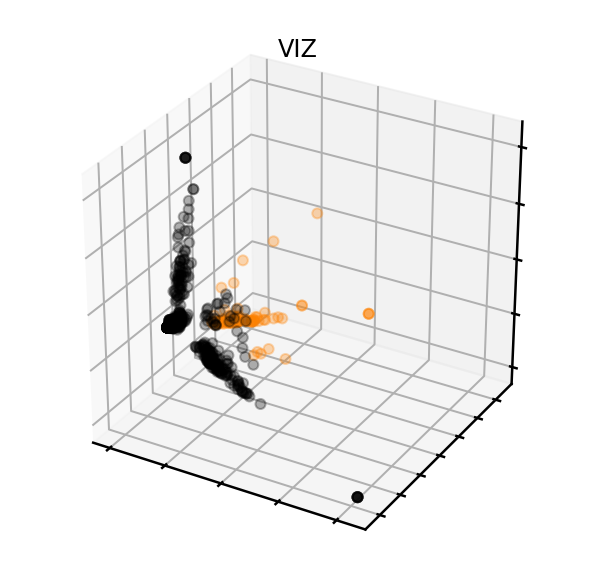

In [15]:
plot_sample = np.random.choice(len(X2), replace=False, size=1000)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

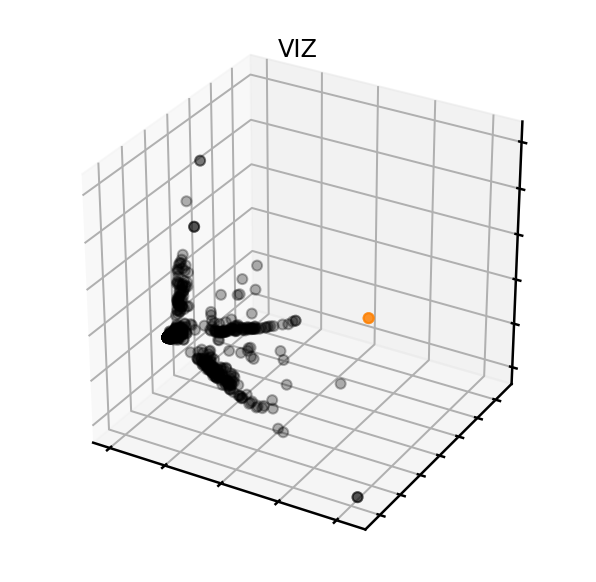

In [16]:
plot_vectors(X2[sample[:1000]], labels=agg_sample[:1000])

It seems like clusters are not well separated. I tried with 2, 3 and 10 clusters.

But how can we find the right number of cluster?

One way is to use a dendrogram.

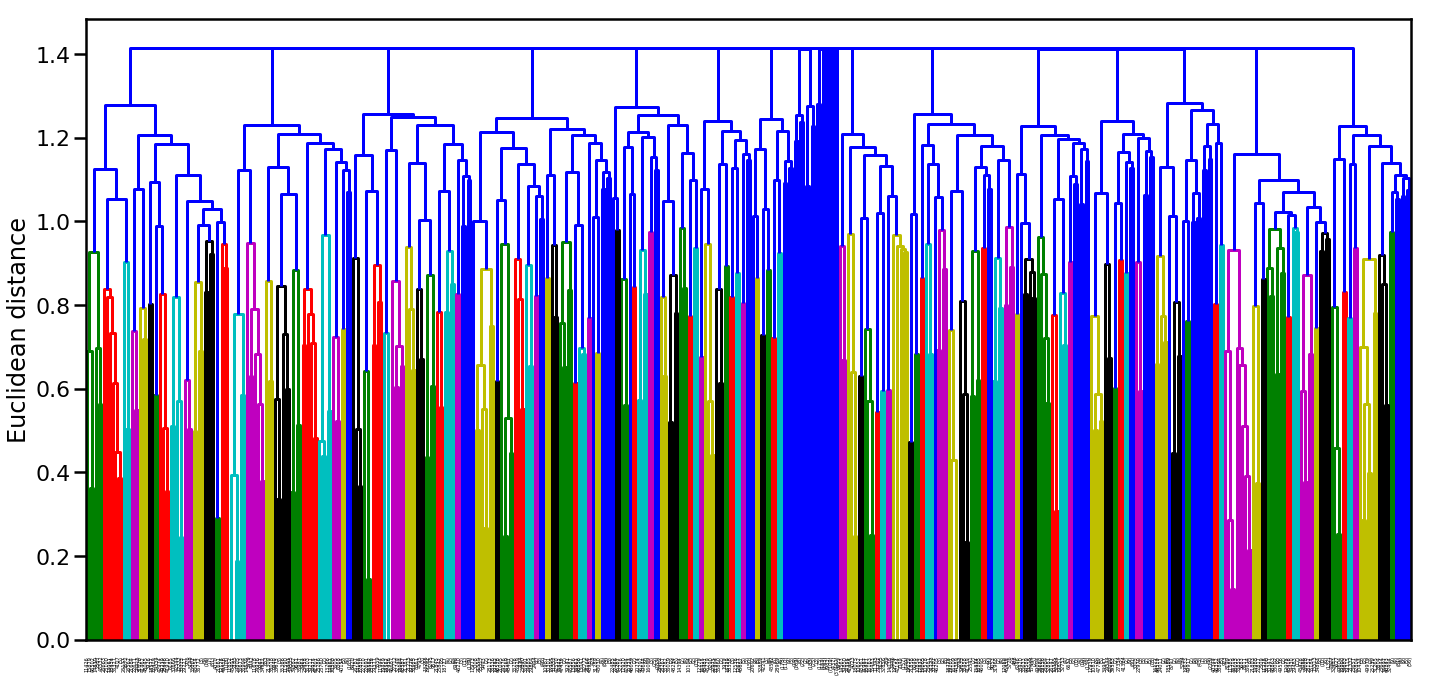

In [20]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

row_clusters = linkage(X2[sample,:], method='complete', metric='euclidean')

plt.figure(figsize = (20, 10))
row_dendr = dendrogram(row_clusters, truncate_mode='level', p = 10)   # dendogram limited to 10 levels for visibility
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

To find the right number of clusters we have to cut the dendrogram horizontally at the highest drops.

In the cell below we can see the truncated dendrograms for different limiting levels.

It seems like the drops are similar to each other, meaning there are no clusters.

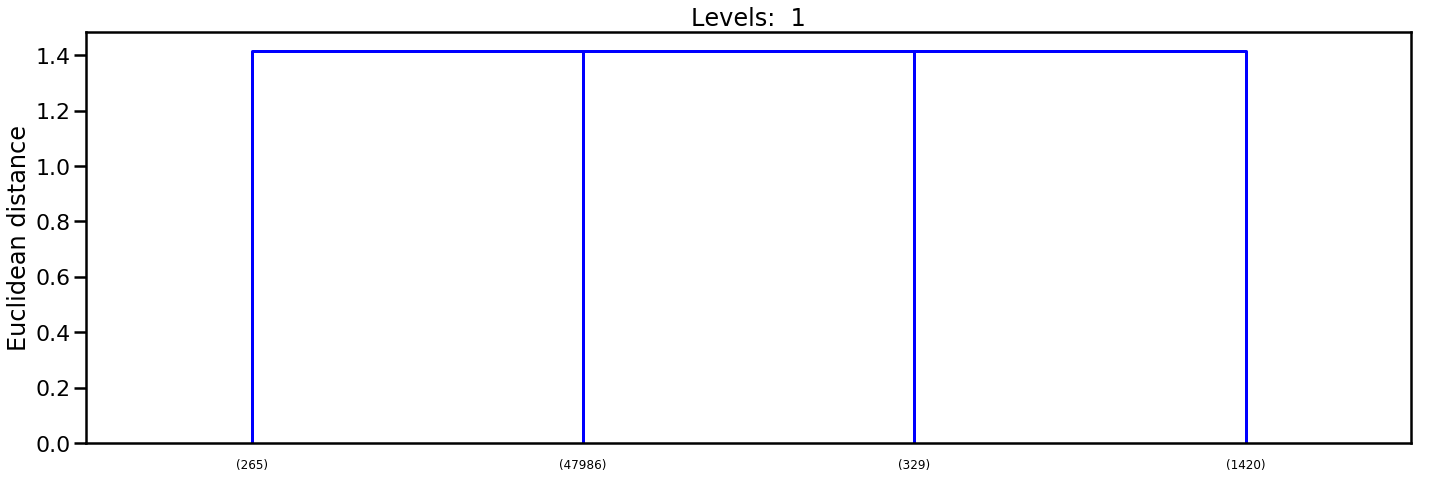

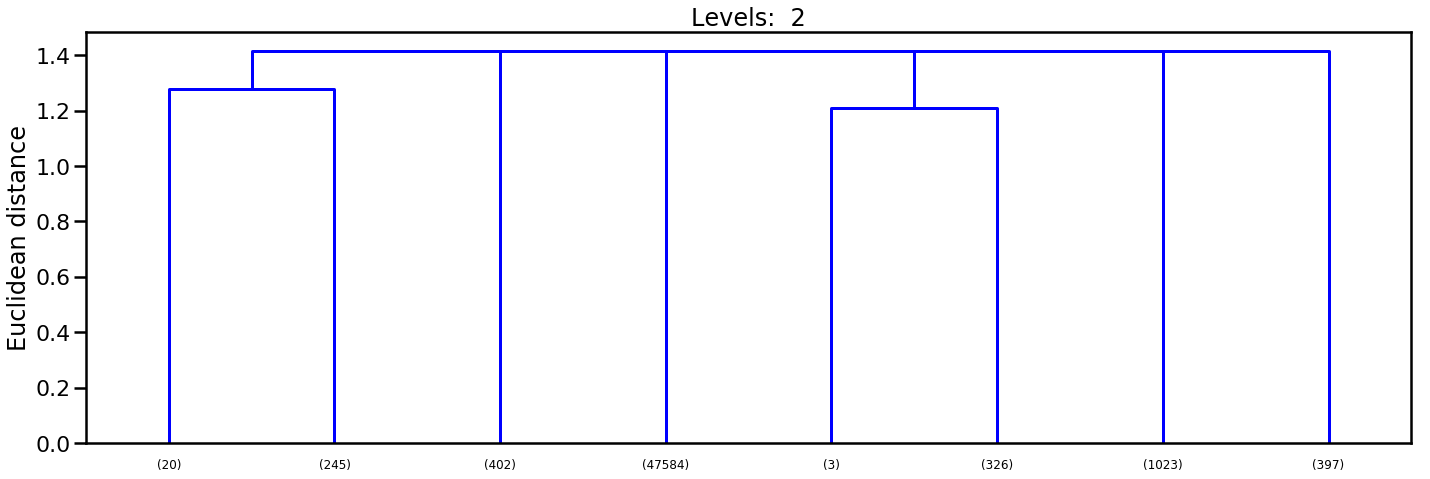

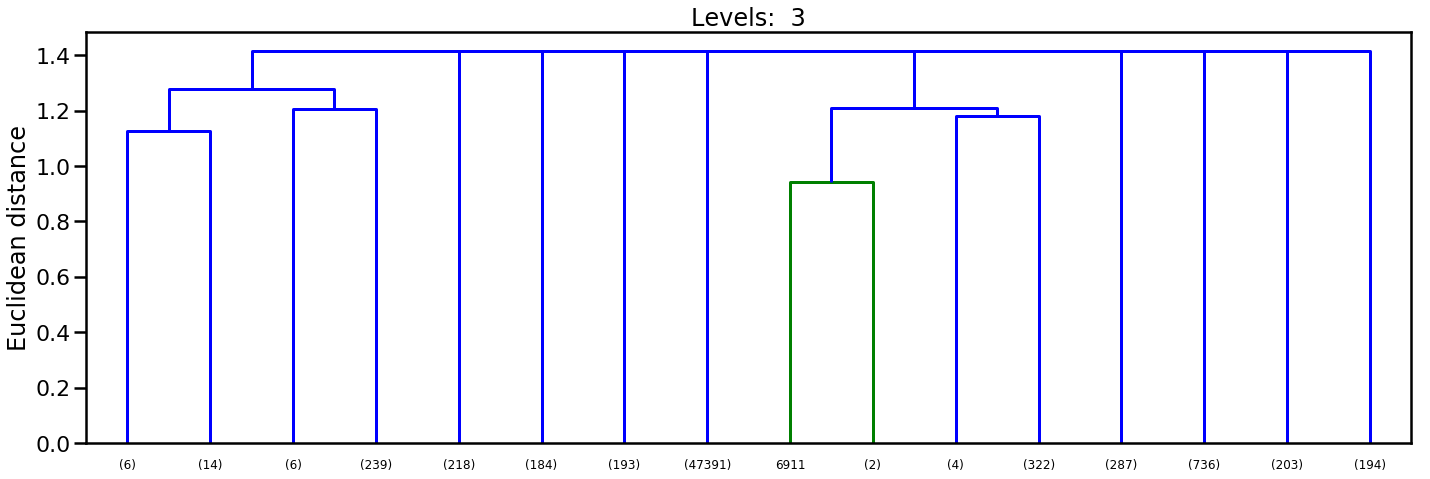

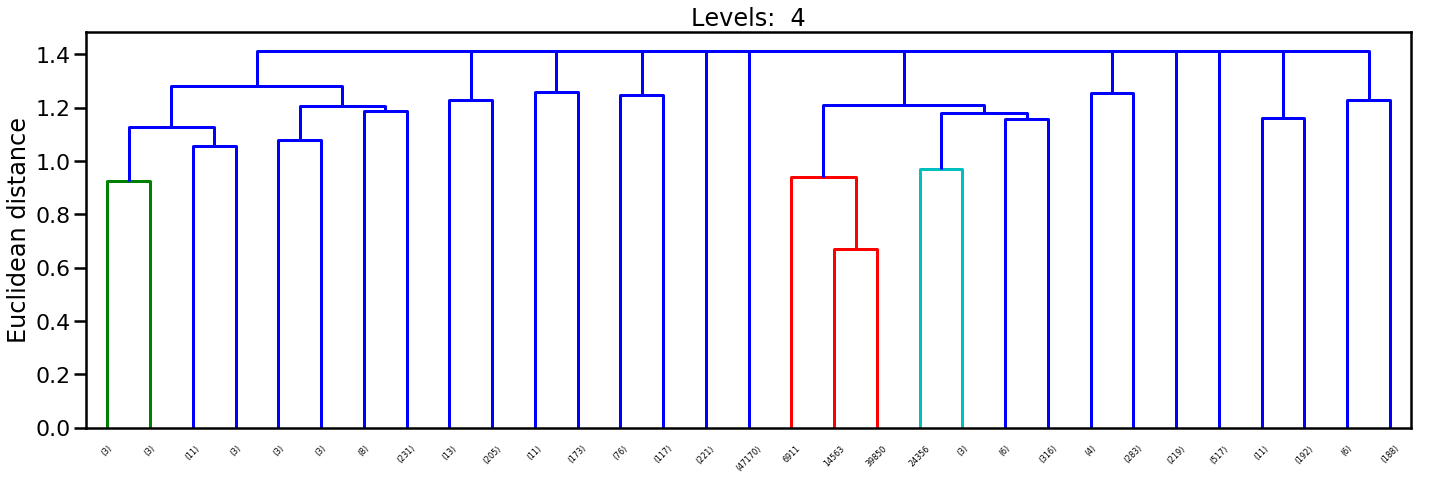

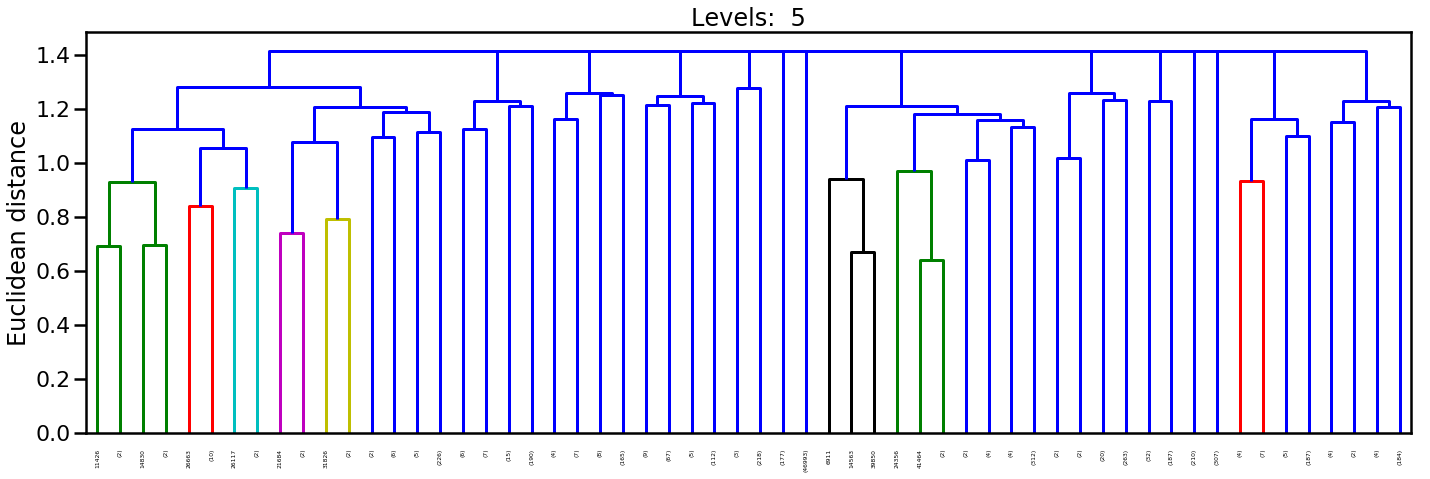

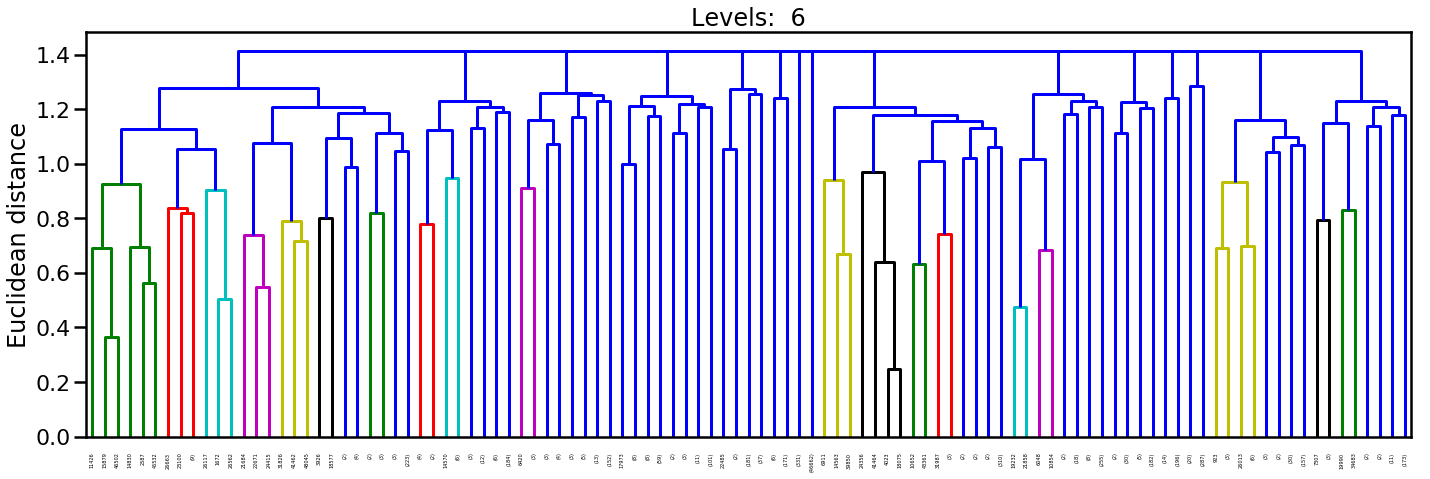

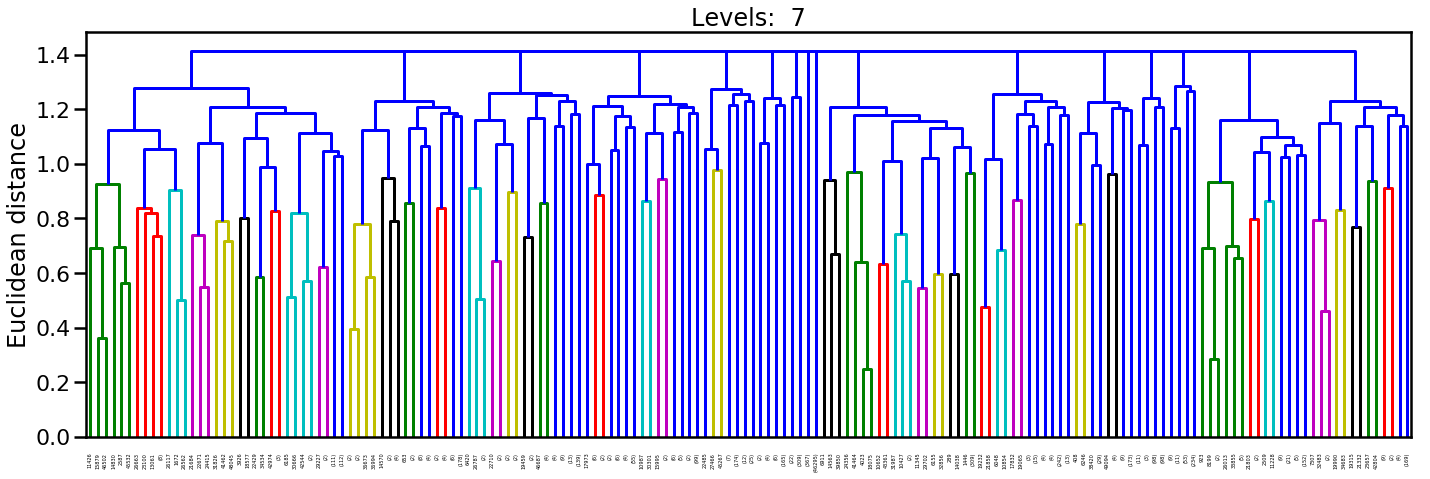

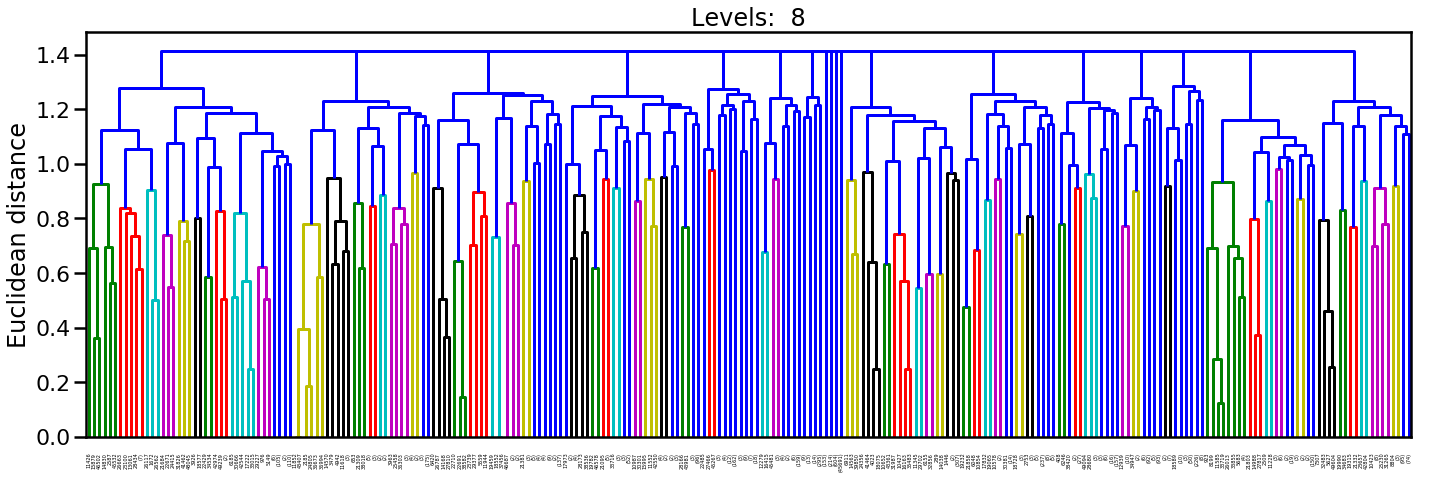

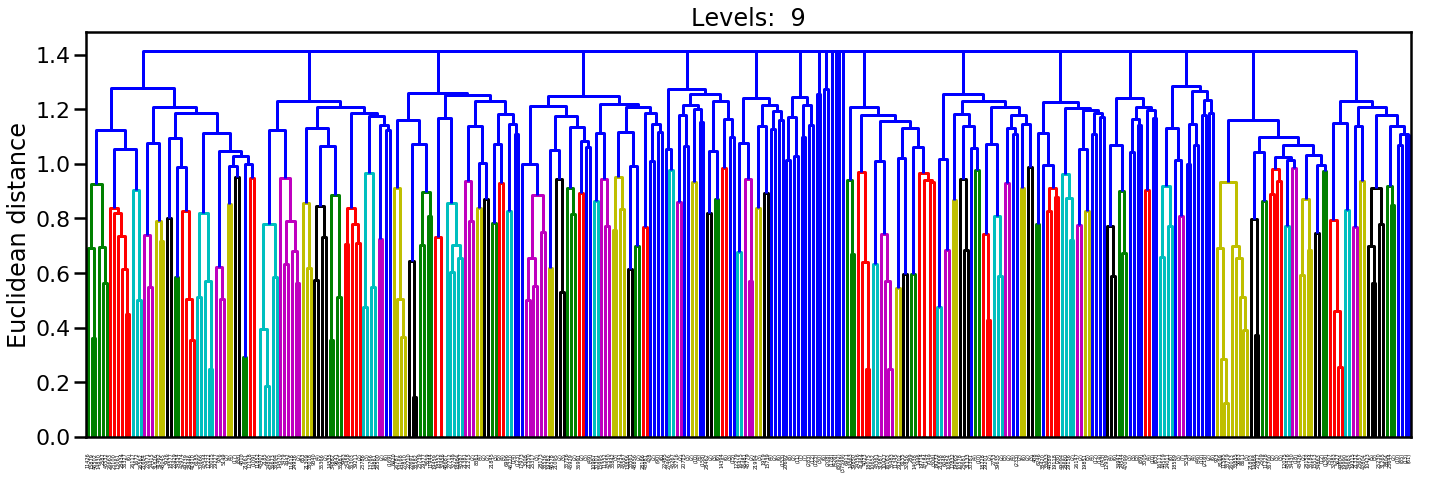

In [51]:
for i in range(1, 10):
    plt.figure(figsize = (20, 7))
    row_dendr = dendrogram(row_clusters, truncate_mode='level', p = i)
    plt.tight_layout()
    plt.title('Levels:  {}'.format(i))
    plt.ylabel('Euclidean distance')
    plt.show()